In [35]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import random

## Espacios Públicos Gdl

In [2]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf = aup.gdf_from_db(table,schema)
gdf.head()

,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."
2,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672494.325 2272095.205, 672480.366 2..."
3,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672480.366 2272060.731, 672494.325 2..."
4,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672468.717 2272020.613, 672456.895 2..."


## Hexágonos Gdl

In [3]:
hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
c = 'Guadalajara'
n = '11'
query = f'SELECT hex_id, geometry, city FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{c}\' AND \"res\" = {n}'
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdl.head(5)

,hex_id,geometry,city
0,8b49ab4b42d4fff,"POLYGON ((-103.42329 20.71934, -103.42311 20.7...",Guadalajara
1,8b49ab4b42f5fff,"POLYGON ((-103.42428 20.71844, -103.42411 20.7...",Guadalajara
2,8b49ab4b4306fff,"POLYGON ((-103.42486 20.71260, -103.42469 20.7...",Guadalajara
3,8b49ab4b4255fff,"POLYGON ((-103.42703 20.71818, -103.42686 20.7...",Guadalajara
4,8b49ab4b42d6fff,"POLYGON ((-103.42281 20.71955, -103.42264 20.7...",Guadalajara


In [4]:
hex_gdl.shape

(407141, 3)

In [5]:
gdf = gdf.to_crs(hex_gdl.crs)
print("CRS of gdf:", gdf.crs)
print("CRS of hex_gdl:", hex_gdl.crs)

CRS of gdf: epsg:4326
CRS of hex_gdl: epsg:4326


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [6]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl.head()

,hex_id,geometry,city,EspPublico
0,8b49ab4b42d4fff,"POLYGON ((-103.42329 20.71934, -103.42311 20.7...",Guadalajara,0
1,8b49ab4b42f5fff,"POLYGON ((-103.42428 20.71844, -103.42411 20.7...",Guadalajara,0
2,8b49ab4b4306fff,"POLYGON ((-103.42486 20.71260, -103.42469 20.7...",Guadalajara,0
3,8b49ab4b4255fff,"POLYGON ((-103.42703 20.71818, -103.42686 20.7...",Guadalajara,1
4,8b49ab4b42d6fff,"POLYGON ((-103.42281 20.71955, -103.42264 20.7...",Guadalajara,0


In [7]:
contador_ceros = np.sum(hex_gdl['EspPublico'] == 0)
contador_uno = np.sum(hex_gdl['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 300548 
Número de Hexágonos con Espacios Públicos: 106593
Número total de Hexágonos: 407141


Casi el 75% de los hexágonos no cuenta con Espacio Público, los métodos de clasificación van a estar muy sesgados por la discrepancia. Entonces tenemos que hacer que sean 50% ambos pero para esto vamos a hacer un submuestreo random con 100,000 y 100,000 de cada tipo de hexágono pero eso se hará después de juntar todo.

## Hexágonos con info de humedad, vegetación y temperatura

select {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res,

temp_diff_mean,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.temperature_analysis_hex tempe

inner join raster_analysis.ndmi_analysis_hex ndmi

on tempe.hex_id = ndmi.hex_id 

inner join raster_analysis.ndvi_analysis_hex ndvi

on tempe.hex_id = ndvi.hex_id 

where tempe.city  = 'Guadalajara' and tempe.res = 11

In [8]:
hex_schema = "raster_analysis"
hex_table = "temperature_analysis_hex"
hex_tabl = "ndvi_analysis_hex"
hex_tablee = "ndmi_analysis_hex"
tempe = "tempe"
ndmi = "ndmi"
ndvi = "ndvi"
hex_id = "hex_id"
c = 'Guadalajara'
n = '11'
query = f'SELECT {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res, temp_diff_mean,ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,ndmi_mean, ndmi_median, ndmi_diff FROM {hex_schema}.{hex_table} {tempe} INNER JOIN {hex_schema}.{hex_tablee} {ndmi} ON {tempe}.{hex_id} = {ndmi}.{hex_id} INNER JOIN {hex_schema}.{hex_tabl} {ndvi} ON {tempe}.{hex_id} = {ndvi}.{hex_id} WHERE {tempe}.\"city\" = \'{c}\' AND {tempe}.\"res\" = {n}'
intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,geometry,city,res,temp_diff_mean,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b49ab4b42e2fff,"POLYGON ((-103.42471 20.71872, -103.42454 20.7...",Guadalajara,11,0.974132,0.114289,0.049750,0.099478,0.194668,0.065362,0.129307,-0.000938,-0.035880,-0.050857,0.202784
1,8b49ab4b42cefff,"POLYGON ((-103.42499 20.72046, -103.42482 20.7...",Guadalajara,11,-0.379456,0.224639,0.081781,0.216309,0.322233,0.129293,0.192940,-0.001084,0.009989,0.005061,0.193035
2,8b49ab4b43aefff,"POLYGON ((-103.42292 20.71391, -103.42274 20.7...",Guadalajara,11,-2.462921,0.351869,0.089766,0.372834,0.431929,0.227313,0.204616,-0.001806,0.089015,0.083834,0.117537
3,8b49ab483075fff,"POLYGON ((-103.45665 20.80869, -103.45647 20.8...",Guadalajara,11,-0.282639,0.296540,0.058069,0.311797,0.343975,0.191514,0.152461,-0.001677,0.122609,0.123036,0.099242
4,8b49ab4830d1fff,"POLYGON ((-103.45271 20.81180, -103.45253 20.8...",Guadalajara,11,-0.056597,0.440252,0.260666,0.418498,0.781023,0.128774,0.652249,-0.000837,0.112624,0.077349,0.444625
5,8b49ab4aa672fff,"POLYGON ((-103.49821 20.79712, -103.49803 20.7...",Guadalajara,11,-0.543837,0.070821,0.022515,0.072187,0.098399,0.045383,0.053017,-0.000515,-0.090500,-0.096391,0.086884
6,8b49ab4aa685fff,"POLYGON ((-103.49365 20.79724, -103.49348 20.7...",Guadalajara,11,-0.814641,0.280972,0.085220,0.282793,0.406992,0.169184,0.237808,-0.001173,-0.016035,-0.027959,0.129138
7,8b49ab4aa770fff,"POLYGON ((-103.49902 20.79351, -103.49884 20.7...",Guadalajara,11,-0.946701,0.300995,0.081917,0.286113,0.402929,0.185886,0.217043,-0.001576,0.014601,0.007157,0.144817
8,8b49ab4aa661fff,"POLYGON ((-103.50048 20.79706, -103.50031 20.7...",Guadalajara,11,-0.433420,0.093078,0.029451,0.090250,0.131413,0.057736,0.073677,-0.000434,-0.075139,-0.077203,0.101216
9,8b49ab4aa68bfff,"POLYGON ((-103.49394 20.79898, -103.49376 20.7...",Guadalajara,11,-0.737586,0.361530,0.088077,0.361740,0.457906,0.240281,0.217625,-0.001556,0.040646,0.034558,0.147207


## Intersección

In [9]:
intt_gdl = intt_gdl.set_crs("EPSG:4326")
hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [ ]:
inter = gpd.sjoin(hex_gdl, intt_gdl, op='intersects')
inter.drop(columns=['index_right','city_right','res','hex_id_right'], inplace=True)
inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)
inter.head()

In [11]:
pd.isna(inter).sum()

hex_id            0
geometry          0
city              0
EspPublico        0
temp_diff_mean    0
ndvi_mean         0
ndvi_std          0
ndvi_median       0
ndvi_max          0
ndvi_min          0
ndvi_diff         0
ndvi_tend         0
ndmi_mean         0
ndmi_median       0
ndmi_diff         0
dtype: int64

In [12]:
cont_ceros = np.sum(inter['EspPublico'] == 0)
cont_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros+cont_uno}')

Números de hexagonos sin Espacios Públicos: 2038369 
Número de Hexágonos con Espacios Públicos: 736626
Número total de Hexágonos: 2774995


In [13]:
inter['EspPublico'].unique()

array([0, 1])

## Submuestreo 100,000 Hexágonos Esp Púb x 100,000 Hexágonos No Esp Púb

In [41]:
num_samples = 150000

# Randomly sample 100,000 hexagons with public spaces
sample_with_public_spaces = inter[inter['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 100,000 hexagons without public spaces
sample_without_public_spaces = inter[inter['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
inter.reset_index(drop = True, inplace = True)
inter.head()

ValueError: Cannot take a larger sample than population when 'replace=False'

In [15]:
contador_ceros = np.sum(inter['EspPublico'] == 0)
contador_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 100000 
Número de Hexágonos con Espacios Públicos: 100000
Número total de Hexágonos: 200000


In [16]:
inter.shape

(200000, 15)

Ya está balanceada la base de datos y con un submuestreo random. Entonces ya podemos juntarlo con el otro GeoDataFrame

Verificamos duplicados

## Métodos de Clasificación

In [19]:
x = inter[['temp_diff_mean','ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff']]
y = inter['EspPublico']

In [20]:
y.values

array([1, 1, 1, ..., 0, 0, 0])

### Regresión Logística

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

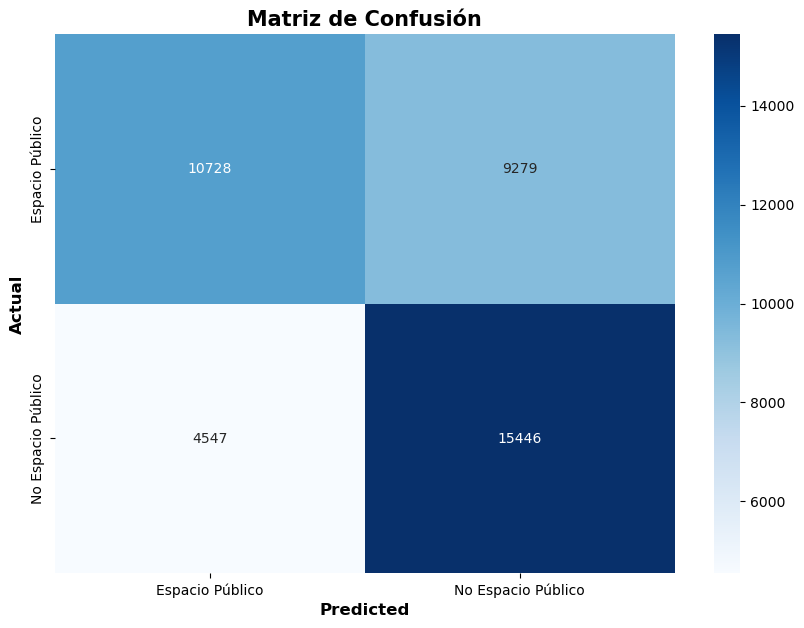

In [22]:
clf = LogisticRegression()
clf.fit(x_train_scale, y_train)
y_pred = clf.predict(x_test_scale)
cm = confusion_matrix(y_test,y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.65435


### Naive Bayes

In [24]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

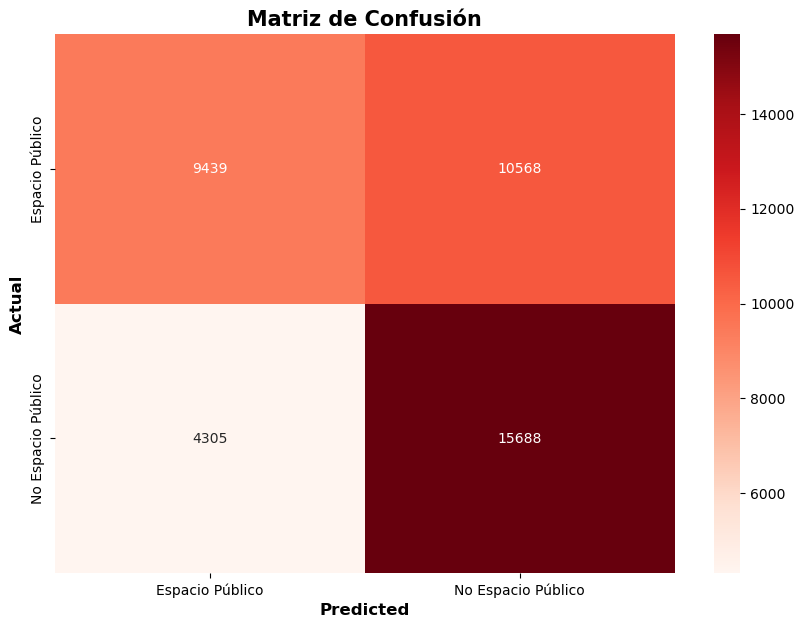

In [25]:
y_prend = nb.predict(x_test)
cm = confusion_matrix(y_test, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [26]:
accuracy = accuracy_score(y_test, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.628175


## Random Forest Classifier (RFC)

In [31]:
rf = RandomForestClassifier(n_estimators=120, random_state=42)  
rf.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predd = rf.predict(x_test)

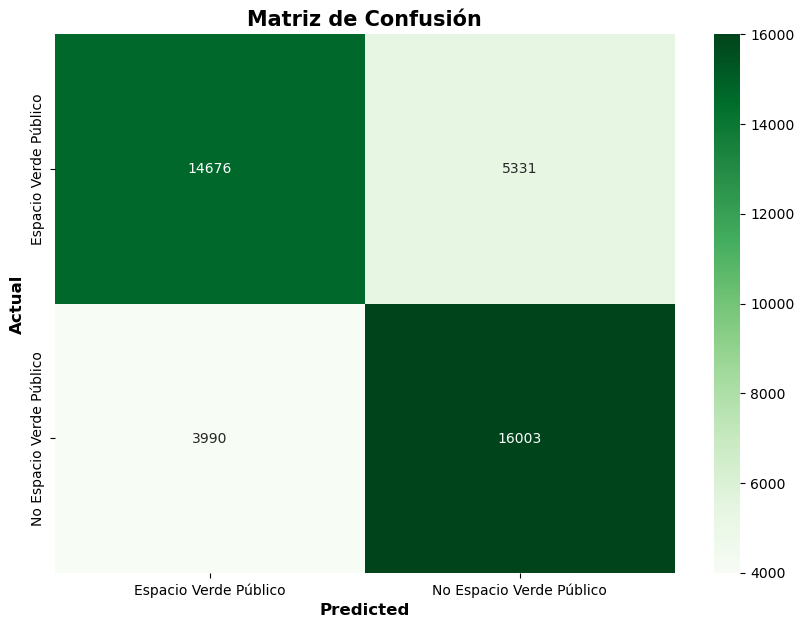

In [32]:
cm = confusion_matrix(y_test, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [33]:
accuracy = accuracy_score(y_test, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.766975


## XGBoost

In [37]:
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
xgb_classifier.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predict = xgb_classifier.predict(x_test)

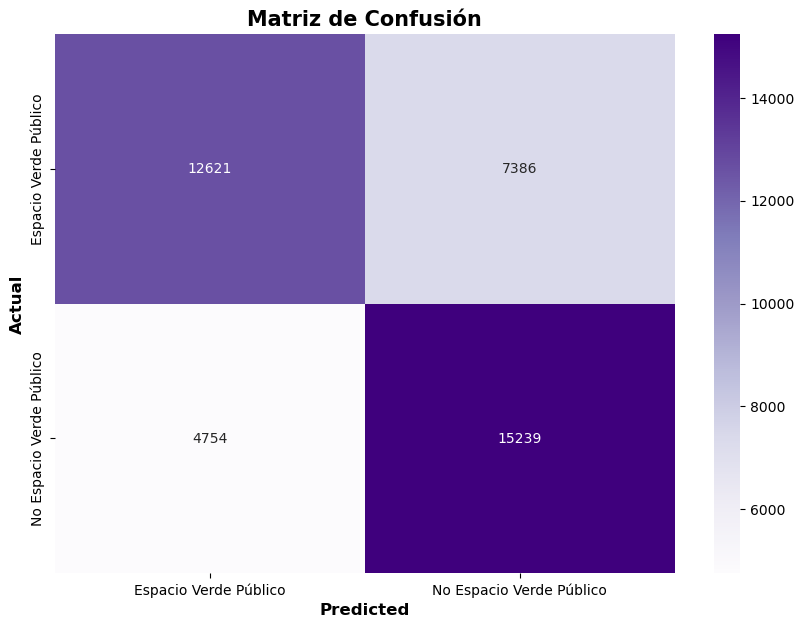

In [39]:
cm = confusion_matrix(y_test, y_predict)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [40]:
accuracy = accuracy_score(y_test, y_predict)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6965


Podemos observar que al tener menos datos la clasificación con Naive Bayes y Regresión logística salió peor que con toda la información. Sin embargo, el random forest classifier es el que mejor ha predecido con un 77%